<a href="https://www.kaggle.com/code/meetkevadiya037/project-2?scriptVersionId=125327532" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="1"></a> <br>

# 1. Import Libraries
([Go to top](#top))

In [21]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from collections import Counter
from pathlib import Path
import os
import numpy as np
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
import unicodedata
import html
stop_words = stopwords.words('english')

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE 

<a id="2"></a> <br>

# 2. Load Data
([Go to top](#top))


In [3]:
t_set = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
t_set.shape

(7613, 5)

In [ ]:
t_set.head()

For training our deep learning model, we will use the 'text' column as our input feature or `Train_X`, and the 'target' column as our output or `Train_Y`. Any other columns that are not required will be dropped as we are only interested in the 'text' column.

In [4]:
raw_training = t_set['text'].values

In [5]:
raw_training.shape

(7613,)

In [6]:
raw_training[5]

'#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'

In [7]:
_ = list(map(print, raw_training[:5]+'\n'))

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

Forest fire near La Ronge Sask. Canada

All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected

13,000 people receive #wildfires evacuation orders in California 

Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 



In [8]:
Train_Y = t_set['target'].values

In [9]:
Train_Y.shape

(7613,)

In [10]:
Train_Y[:5]

array([1, 1, 1, 1, 1])

<a id="3"></a> <br>

# 3. Data Splitting
([Go to top](#top))

As we see there's a little bit class imbalance, so we'll use `stratify` parameter with `train_test_split`.

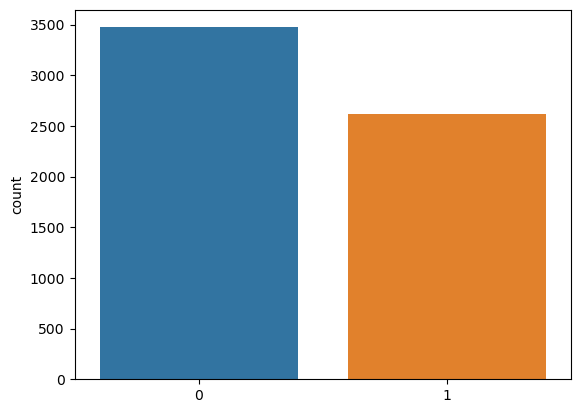

In [12]:
_ = sns.countplot(x=Train_Y)

In [11]:
from sklearn.model_selection import train_test_split

raw_training, Validate_X_raw, Train_Y, y_validation = train_test_split(raw_training, Train_Y, test_size=0.2, stratify=Train_Y)

print(raw_training.shape)
print(Train_Y.shape)
print()
print(Validate_X_raw.shape)
print(y_validation.shape)

(6090,)
(6090,)

(1523,)
(1523,)


<a id="4"></a> <br>

# 4. Text Preprocessing
([Go to top](#top))

In this phase, we apply some operations on the text, to make it in the most usable form for the task at hand. Mainly we clean it up to be more appealing to the problem we try to solve. The input is __text__ and the output is a transformed __text__.

In [30]:
def remove_special_chars(text):
    recoup = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return recoup.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    Port_stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
  return word_tokenize(text)

def normalize_text(text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

In [31]:
Train_X_clean = raw_training.copy()
Validate_X_clean = Validate_X_raw.copy()

Train_X_clean = list(map(normalize_text, Train_X_clean))
Validate_X_clean = list(map(normalize_text, Validate_X_clean))

# Train_X_clean

<a id="5"></a> <br>

# 5. Model
([Go to top](#top))

In [32]:
evaluation_df = pd.DataFrame()
models_dict = {}

<a id="5.1"></a> <br>

## 5.1 BOW
([Go to top](#top))


<a id="5.1.1"></a> <br>

##### Text Preparation for BOW

In [33]:
vectorizer = CountVectorizer()
Train_X = vectorizer.fit_transform(Train_X_clean)
Validate_X = vectorizer.transform(Validate_X_clean)

In [ ]:
# vectorizer.vocabulary_

In [34]:
Train_X = Train_X.toarray()
Validate_X = Validate_X.toarray()

In [35]:
print(Train_X.shape)
print(Validate_X.shape)

(6090, 16251)
(1523, 16251)


<a id="5.1.2"></a> <br>

##### Building Model

In [36]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(Train_X.shape[1],)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                260032    
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 260,321
Trainable params: 260,321
Non-trainable params: 0
_________________________________________________________________


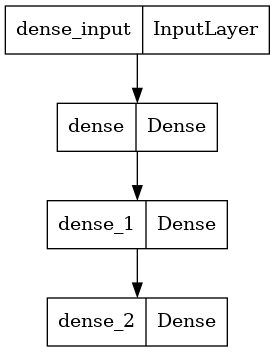

In [38]:
from keras.utils import plot_model
plot_model(model)

In [39]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [40]:
history = model.fit(Train_X,
                    Train_Y,
                    epochs=50,
                    batch_size=512,
                    validation_data=(Validate_X, y_validation))

Epoch 1/50
12/12 [==============================] - 3s 137ms/step - loss: 0.6726 - accuracy: 0.6631 - val_loss: 0.6402 - val_accuracy: 0.7741
Epoch 2/50
12/12 [==============================] - 1s 82ms/step - loss: 0.5999 - accuracy: 0.8189 - val_loss: 0.5849 - val_accuracy: 0.8050
Epoch 3/50
12/12 [==============================] - 1s 80ms/step - loss: 0.5229 - accuracy: 0.8678 - val_loss: 0.5390 - val_accuracy: 0.8142
Epoch 4/50
12/12 [==============================] - 1s 77ms/step - loss: 0.4526 - accuracy: 0.8864 - val_loss: 0.5035 - val_accuracy: 0.8155
Epoch 5/50
12/12 [==============================] - 1s 88ms/step - loss: 0.3900 - accuracy: 0.9071 - val_loss: 0.4769 - val_accuracy: 0.8194
Epoch 6/50
12/12 [==============================] - 1s 89ms/step - loss: 0.3358 - accuracy: 0.9177 - val_loss: 0.4590 - val_accuracy: 0.8201
Epoch 7/50
12/12 [==============================] - 1s 86ms/step - loss: 0.2888 - accuracy: 0.9279 - val_loss: 0.4478 - val_accuracy: 0.8175
Epoch 8/50
1

<a id="5.1.3"></a> <br>

##### Training VS Validation

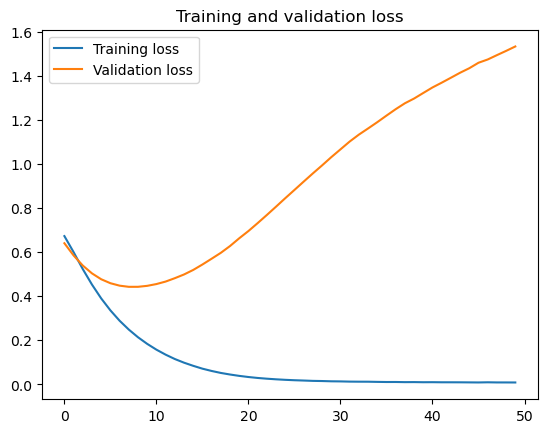

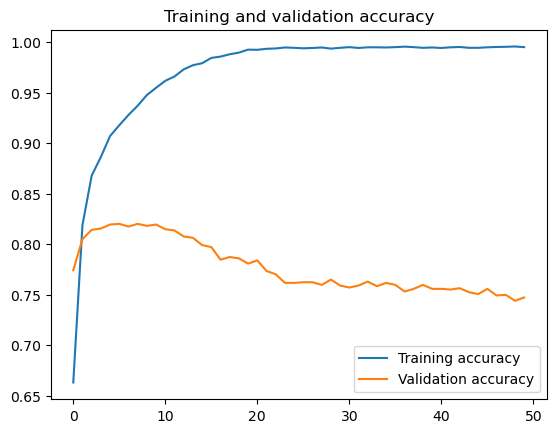

In [41]:
accuracy = history.history['accuracy']
loss = history.history['loss']

validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(accuracy, label='Training accuracy')
plt.plot(validation_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

<a id="5.1.4"></a> <br>

##### Save Model

In [44]:
model.save('/kaggle/working/bow.h5')

<a id="5.1.5"></a> <br>

##### Save Performance

In [46]:
model_name = 'BOW'
models_dict[model_name] = '/kaggle/working/bow.h5'

train_loss, train_accuracy = model.evaluate(Train_X, Train_Y)
validation_loss, validation_accuracy = model.evaluate(Validate_X, y_validation)

evaluation = pd.DataFrame({
                          'Model' : [model_name],
                          'Train' : [train_accuracy],
                          'Validation' : [validation_accuracy]
                        })

evaluation_df = pd.concat([evaluation_df, evaluation], ignore_index=True)

48/48 [==============================] - 0s 4ms/step - loss: 1.5325 - accuracy: 0.7472


<a id="5.2"></a> <br>

## 5.2 BOW Vectors
([Go to top](#top))

<a id="5.2.1"></a> <br>

##### Text Preparation for BOW Vectors

In [48]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(Train_X_clean)
vocab_size = len(tokenizer.word_index) + 1

In [50]:
# integer encode the documents
train_enc = tokenizer.texts_to_sequences(Train_X_clean)
validate_enc = tokenizer.texts_to_sequences(Validate_X_clean)

In [51]:
# print(train_enc)

Determine the optimal maximum padding length

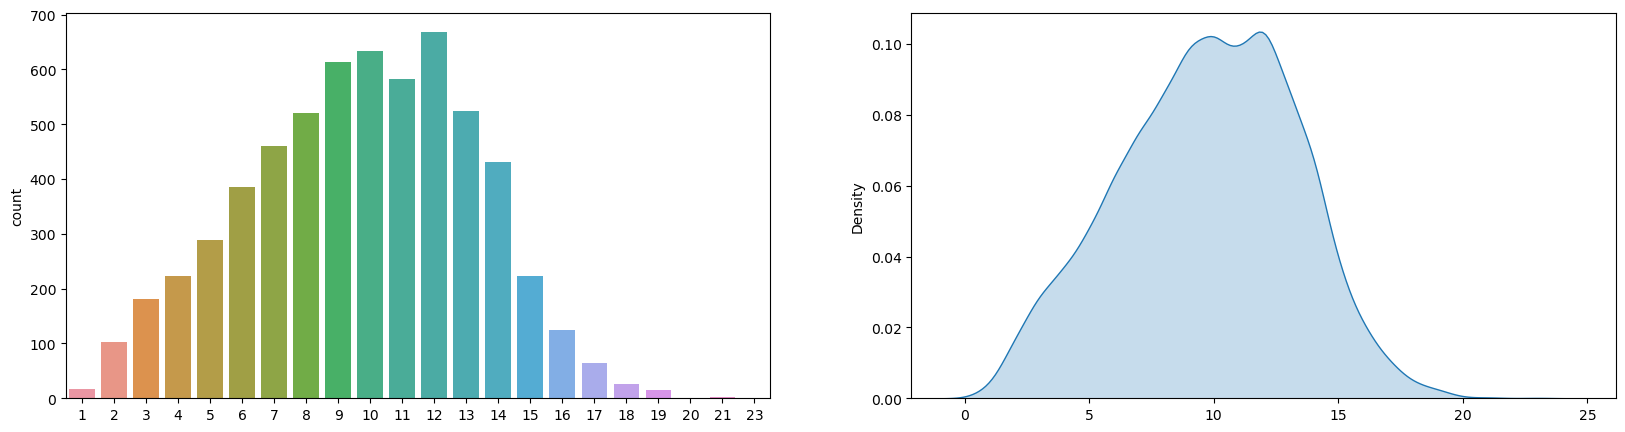

In [52]:
figure, subplots = plt.subplots(1, 2, figsize=(20, 5))
_ = sns.countplot(x=list(map(len, train_enc)), ax=subplots[0])
_ = sns.kdeplot(list(map(len, train_enc)), fill=True, ax=subplots[1])

In [53]:
from statistics import mode
train_enc_len = list(map(len, train_enc))
mode(train_enc_len)

12

As we see the most frequent value in the histogram (mode) = 12.

If we set the max padding length to be equal to the most frequent value in the histogram (mode = 12), let's see how many sentences we can get rid of.

In [54]:
len(list(filter(lambda x: x>=mode(train_enc_len), train_enc_len)))

2083

In [55]:
len(train_enc_len)

6090

We will lose around 34% of the data (6090 tweets).

In [56]:
round(len(list(filter(lambda x: x>=mode(train_enc_len), train_enc_len))) / len(train_enc_len)*100, 2)

34.2

That's why we will set the max padding length to be equal to the length of the longest tweet.

In [57]:
max(train_enc_len)

23

In [58]:
max_length = max(train_enc_len)
train_seq = pad_sequences(train_enc, maxlen=max_length, padding='post')
validate_seq = pad_sequences(validate_enc, maxlen=max_length, padding='post')

In [59]:
print(train_seq)

[[   45    19  4721 ...     0     0     0]
 [  184  4725   139 ...     0     0     0]
 [  514   361  4727 ...     0     0     0]
 ...
 [16270 16271  4072 ...     0     0     0]
 [  533    19    81 ...     0     0     0]
 [  107   141   114 ...     0     0     0]]


<a id="5.2.2"></a> <br>

##### Building Model

In [60]:
c_latent_factors = 32

model = models.Sequential()
model.add(layers.Embedding(vocab_size+1, c_latent_factors, input_length=max_length))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [61]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 32)            520832    
                                                                 
 flatten (Flatten)           (None, 736)               0         
                                                                 
 dense_3 (Dense)             (None, 16)                11792     
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 532,913
Trainable params: 532,913
Non-trainable params: 0
_________________________________________________________________


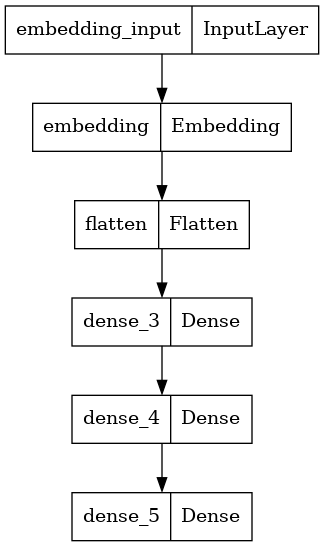

In [62]:
from keras.utils import plot_model
plot_model(model)

In [63]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [64]:
history = model.fit(train_seq,
                    Train_Y,
                    epochs=50,
                    batch_size=512,
                    validation_data=(validate_seq, y_validation))

Epoch 1/50
12/12 [==============================] - 1s 29ms/step - loss: 0.6827 - accuracy: 0.5612 - val_loss: 0.6703 - val_accuracy: 0.5712
Epoch 2/50
12/12 [==============================] - 0s 12ms/step - loss: 0.6453 - accuracy: 0.6304 - val_loss: 0.6314 - val_accuracy: 0.6264
Epoch 3/50
12/12 [==============================] - 0s 13ms/step - loss: 0.5695 - accuracy: 0.7780 - val_loss: 0.5722 - val_accuracy: 0.7413
Epoch 4/50
12/12 [==============================] - 0s 13ms/step - loss: 0.4646 - accuracy: 0.8722 - val_loss: 0.5142 - val_accuracy: 0.7715
Epoch 5/50
12/12 [==============================] - 0s 11ms/step - loss: 0.3579 - accuracy: 0.9030 - val_loss: 0.4684 - val_accuracy: 0.7991
Epoch 6/50
12/12 [==============================] - 0s 12ms/step - loss: 0.2745 - accuracy: 0.9297 - val_loss: 0.4492 - val_accuracy: 0.8056
Epoch 7/50
12/12 [==============================] - 0s 10ms/step - loss: 0.2076 - accuracy: 0.9460 - val_loss: 0.4683 - val_accuracy: 0.8043
Epoch 8/50
12

<a id="5.2.3"></a> <br>

##### Training VS Validation

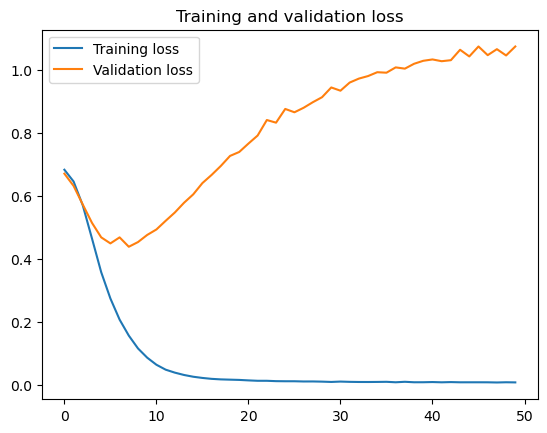

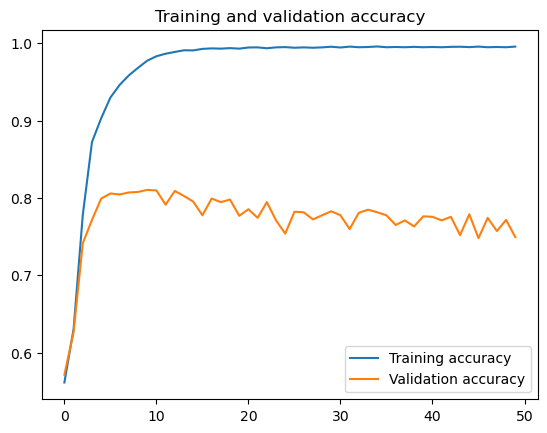

In [65]:
accuracy = history.history['accuracy']
loss = history.history['loss']

validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(accuracy, label='Training accuracy')
plt.plot(validation_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

<a id="5.2.4"></a> <br>

##### Save Model

In [66]:
model.save('/kaggle/working/bow_vectors.h5')

<a id="5.2.5"></a> <br>

##### Save Performance

In [67]:
model_name = 'BOW Vectors'
models_dict[model_name] = '/kaggle/working/bow_vectors.h5'

train_loss, train_accuracy = model.evaluate(train_seq, Train_Y)
validation_loss, validation_accuracy = model.evaluate(validate_seq, y_validation)

evaluation = pd.DataFrame({
                          'Model' : [model_name],
                          'Train' : [train_accuracy],
                          'Validation' : [validation_accuracy]
                        })

evaluation_df = pd.concat([evaluation_df, evaluation], ignore_index=True)

48/48 [==============================] - 0s 2ms/step - loss: 1.0733 - accuracy: 0.7492


<a id="5.3"></a> <br>

## 5.3 LSTM
([Go to top](#top))

<a id="5.3.2"></a> <br>

##### Building Model

In [68]:
c_latent_factors = 32

model = models.Sequential()
model.add(layers.Embedding(vocab_size+1, c_latent_factors, input_length=max_length))
model.add(layers.LSTM(32, dropout=0.2, recurrent_dropout=0.4))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [69]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 32)            520832    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 529,969
Trainable params: 529,969
Non-tr

In [ ]:
from keras.utils import plot_model
plot_model(model)

In [70]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [71]:
history = model.fit(train_seq,
                    Train_Y,
                    epochs=50,
                    batch_size=512,
                    validation_data=(validate_seq, y_validation))

Epoch 1/50
12/12 [==============================] - 5s 102ms/step - loss: 0.6876 - accuracy: 0.5580 - val_loss: 0.6811 - val_accuracy: 0.5706
Epoch 2/50
12/12 [==============================] - 1s 68ms/step - loss: 0.6596 - accuracy: 0.5765 - val_loss: 0.5859 - val_accuracy: 0.6710
Epoch 3/50
12/12 [==============================] - 1s 67ms/step - loss: 0.4784 - accuracy: 0.8123 - val_loss: 0.5027 - val_accuracy: 0.8109
Epoch 4/50
12/12 [==============================] - 1s 66ms/step - loss: 0.3366 - accuracy: 0.8744 - val_loss: 0.4470 - val_accuracy: 0.8168
Epoch 5/50
12/12 [==============================] - 1s 66ms/step - loss: 0.2664 - accuracy: 0.9071 - val_loss: 0.4912 - val_accuracy: 0.8181
Epoch 6/50
12/12 [==============================] - 1s 65ms/step - loss: 0.2144 - accuracy: 0.9248 - val_loss: 0.5093 - val_accuracy: 0.8155
Epoch 7/50
12/12 [==============================] - 1s 70ms/step - loss: 0.1631 - accuracy: 0.9458 - val_loss: 0.5790 - val_accuracy: 0.8096
Epoch 8/50
1

<a id="5.3.3"></a> <br>

##### Training VS Validation

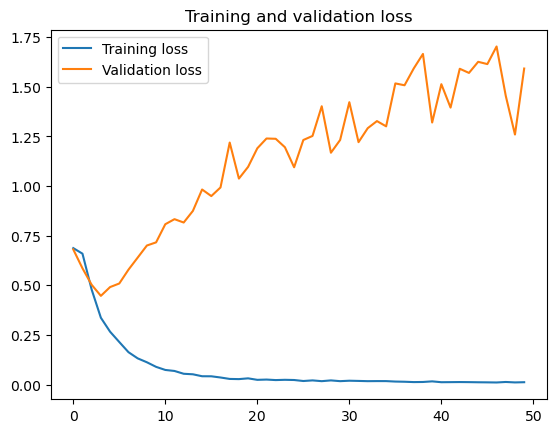

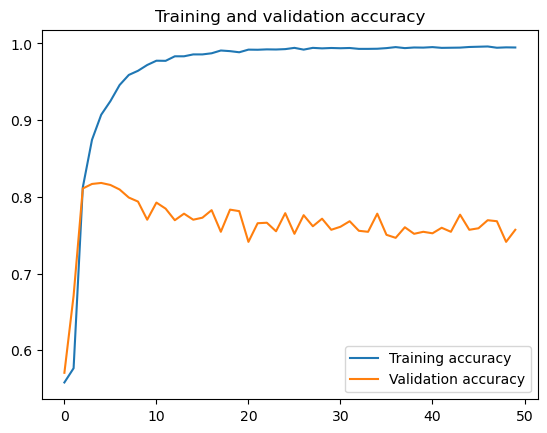

In [72]:
accuracy = history.history['accuracy']
loss = history.history['loss']

validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(accuracy, label='Training accuracy')
plt.plot(validation_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

<a id="5.3.4"></a> <br>

##### Save Model

In [74]:
model.save('/kaggle/working/lstm.h5')

<a id="5.3.5"></a> <br>

##### Save Performance

In [75]:
model_name = 'LSTM'
models_dict[model_name] = '/kaggle/working/lstm.h5'

train_loss, train_accuracy = model.evaluate(train_seq, Train_Y)
validation_loss, validation_accuracy = model.evaluate(validate_seq, y_validation)

evaluation = pd.DataFrame({
                          'Model' : [model_name],
                          'Train' : [train_accuracy],
                          'Validation' : [validation_accuracy]
                        })

evaluation_df = pd.concat([evaluation_df, evaluation], ignore_index=True)

48/48 [==============================] - 0s 6ms/step - loss: 1.5925 - accuracy: 0.7571


<a id="5.4"></a> <br>

## 5.4 GRU
([Go to top](#top))

<a id="5.3.2"></a> <br>

##### Building Model

In [76]:
c_latent_factors = 32

model = models.Sequential()
model.add(layers.Embedding(vocab_size+1, c_latent_factors, input_length=max_length))
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.4))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [77]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 23, 32)            520832    
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 527,985
Trainable params: 527,985
Non-tr

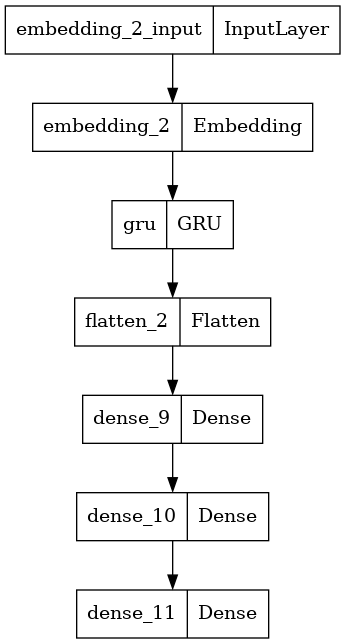

In [78]:
from keras.utils import plot_model
plot_model(model)

In [79]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [80]:
history = model.fit(train_seq,
                    Train_Y,
                    epochs=50,
                    batch_size=512,
                    validation_data=(validate_seq, y_validation))

Epoch 1/50
12/12 [==============================] - 5s 104ms/step - loss: 0.6876 - accuracy: 0.5539 - val_loss: 0.6835 - val_accuracy: 0.5706
Epoch 2/50
12/12 [==============================] - 1s 57ms/step - loss: 0.6834 - accuracy: 0.5703 - val_loss: 0.6831 - val_accuracy: 0.5706
Epoch 3/50
12/12 [==============================] - 1s 58ms/step - loss: 0.6834 - accuracy: 0.5703 - val_loss: 0.6830 - val_accuracy: 0.5706
Epoch 4/50
12/12 [==============================] - 1s 57ms/step - loss: 0.6831 - accuracy: 0.5703 - val_loss: 0.6827 - val_accuracy: 0.5706
Epoch 5/50
12/12 [==============================] - 1s 62ms/step - loss: 0.6804 - accuracy: 0.5703 - val_loss: 0.6747 - val_accuracy: 0.5706
Epoch 6/50
12/12 [==============================] - 1s 59ms/step - loss: 0.6026 - accuracy: 0.6391 - val_loss: 0.5542 - val_accuracy: 0.7853
Epoch 7/50
12/12 [==============================] - 1s 58ms/step - loss: 0.4695 - accuracy: 0.8471 - val_loss: 0.5266 - val_accuracy: 0.8063
Epoch 8/50
1

<a id="5.3.3"></a> <br>

##### Training VS Validation

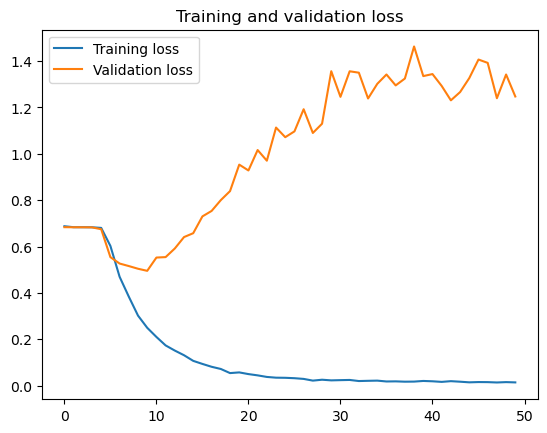

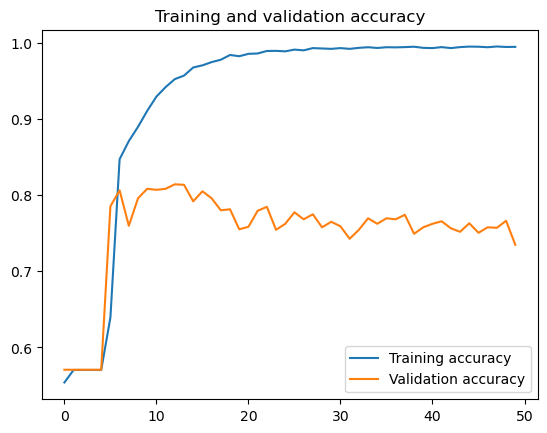

In [81]:
accuracy = history.history['accuracy']
loss = history.history['loss']

validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(accuracy, label='Training accuracy')
plt.plot(validation_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

<a id="5.4.4"></a> <br>

##### Save Model

In [82]:
model.save('/kaggle/working/gru.h5')

<a id="5.4.5"></a> <br>

##### Save Performance

In [83]:
model_name = 'GRU'
models_dict[model_name] = '/kaggle/working/gru.h5'

train_loss, train_accuracy = model.evaluate(train_seq, Train_Y)
validation_loss, validation_accuracy = model.evaluate(validate_seq, y_validation)

evaluation = pd.DataFrame({
                          'Model' : [model_name],
                          'Train' : [train_accuracy],
                          'Validation' : [validation_accuracy]
                        })

evaluation_df = pd.concat([evaluation_df, evaluation], ignore_index=True)

48/48 [==============================] - 0s 5ms/step - loss: 1.2473 - accuracy: 0.7347


<a id="6"></a> <br>

# 6. Evaluation
([Go to top](#top))

In [84]:
evaluation_df

,Model,Train,Validation
0,BOW,0.996388,0.747209
1,BOW,0.996388,0.747209
2,BOW Vectors,0.994253,0.749179
3,LSTM,0.996552,0.757058
4,GRU,0.995238,0.734734


In [85]:
from keras.models import load_model

# Get best model according to validation score.
best_model = evaluation_df[evaluation_df['Validation'] == evaluation_df['Validation'].max()]['Model'].values[0]

In [86]:
best_model

'LSTM'

In [87]:
model = load_model(models_dict[best_model])

In [88]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 32)            520832    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 529,969
Trainable params: 529,969
Non-tr

Providing Test dataset to the model to calculate accuracy

In [89]:
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_data.shape

(3263, 4)

In [90]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [91]:
# Text preprocessing utilized during training

test_data['clean text'] = test_data['text'].apply(normalize_text)
test_data.head()

,id,keyword,location,text,clean text
0,0,NaN,NaN,Just happened a terrible car crash,happen terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe everyone
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose flee across street...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse light spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


In [93]:
# Get the appropriate preparation based on model

if best_model == 'BOW':
  X_test = vectorizer.transform(test_data['clean text'])
  X_test = X_test.toarray()

else:
  X_test = tokenizer.texts_to_sequences(test_data['clean text'])
  X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

In [94]:
predictions = model.predict(X_test).round()

102/102 [==============================] - 1s 5ms/step


In [95]:
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = np.round(predictions).astype('int')
submission.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,1
4,11,1


In [96]:
submission.to_csv('Final_Output.csv', index=False)